# Visualize the parameter gradients of the inverse CDF function over the parameter space



In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
log, log2, exp, exp2 = torch.log, torch.log2, torch.exp, torch.exp2
ln4 = log(torch.tensor(4))
from config import FIGURES_DIR

In [36]:
u_min_32 = torch.tensor(2**-149, dtype=torch.float32)
u_max_32 = torch.tensor(1 - 2**-24, dtype=torch.float32)

u_min_64 = torch.tensor(2**-1074, dtype=torch.float64)
u_max_64 = torch.tensor(1 - 2**-53, dtype=torch.float64)

def safe_z(beta: torch.Tensor, u: torch.Tensor, min: float, max: float) -> torch.Tensor:
    # Wherever z fails, replace it with the taylor expansion

    # z can face domain error for u too small or large.
    # Clamp u below (to smallest representable number) to ensure log2(u) is finite
    # Allow z to fail from above, as this is where the taylor expansion will be used
    z = log2(1 - exp2(beta * log2(u.clamp(min=min))))
    
    # by clamping u above, we ensure this must be finite
    # Can face domain error for u > max = 1 - 2^-m. Clamp to ensure taylor expansion is finite.
    z_taylor = log2(beta) + log2(1 - u.clamp(max=max))
    #print(f'raw z: {z.item():.20f}, taylor z: {z_taylor.item():.20f}')
    
    # where z if not finite, replace with taylor expansion
    return torch.where(torch.isfinite(z), z, z_taylor)

In [37]:
def kumaraswamy_inverse_cdf_and_gradients(u, ell_alpha, ell_beta, dtype=torch.float32):
    alpha, beta = exp2(ell_alpha), exp2(ell_beta)
    u_min, u_max = (u_min_32, u_max_32) if dtype == torch.float32 else (u_min_64, u_max_64)

    ell_u = log2(u.clamp(min=u_min))
    c = ell_u * beta
    z = safe_z(beta, u, u_min, u_max)
    #z = log2(1-exp2(c))
    F_inv = exp2(alpha * z)
    nabla_ell_alpha = exp2(ell_alpha + alpha * z) * z * ln4
    nabla_ell_beta = -1 * exp2(ell_alpha + ell_beta + c + (alpha - 1) * z) * ell_u * ln4
    return F_inv, nabla_ell_alpha, nabla_ell_beta

In [39]:
#### DTYPE FOR ACCURACY ####
dtype = torch.float64

x = torch.linspace(0, 1, 10000, dtype=dtype)
x = x.view(-1, 1, 1)

# Define your mesh grid
low_lim, high_lim = -10, 5
num_points = 200
log_alpha = torch.linspace(low_lim, high_lim, num_points, dtype=dtype)
log_beta = torch.linspace(low_lim, high_lim, num_points, dtype=dtype)
A_, B_ = torch.meshgrid(log_alpha, log_beta, indexing='ij')

F_inv, nabla_a_F_inv, nabla_b_F_inv = kumaraswamy_inverse_cdf_and_gradients(x, A_, B_)

In [40]:
# summarize number of nan/inf values 
num_x_samples = x.shape[0]
num_nan_F_inv = torch.sum(torch.isnan(F_inv))
num_inf_F_inv = torch.sum(torch.isinf(F_inv))

num_nan_nabla_a_F_inv = torch.sum(torch.isnan(nabla_a_F_inv))
num_inf_nabla_a_F_inv = torch.sum(torch.isinf(nabla_a_F_inv))

num_nan_nabla_b_F_inv = torch.sum(torch.isnan(nabla_b_F_inv))
num_inf_nabla_b_F_inv = torch.sum(torch.isinf(nabla_b_F_inv))

In [41]:
print(f"Number of NaN values in F_inv: {num_nan_F_inv}/{num_x_samples*num_points*num_points}")
print(f"Number of Inf values in F_inv: {num_inf_F_inv}/{num_x_samples*num_points*num_points}")

print(f"Number of NaN values in nabla_a_F_inv: {num_nan_nabla_a_F_inv}/{num_x_samples*num_points*num_points}")
print(f"Number of Inf values in nabla_a_F_inv: {num_inf_nabla_a_F_inv}/{num_x_samples*num_points*num_points}")

print(f"Number of NaN values in nabla_b_F_inv: {num_nan_nabla_b_F_inv}/{num_x_samples*num_points*num_points}")
print(f"Number of Inf values in nabla_b_F_inv: {num_inf_nabla_b_F_inv}/{num_x_samples*num_points*num_points}")

Number of NaN values in F_inv: 0/400000000
Number of Inf values in F_inv: 0/400000000
Number of NaN values in nabla_a_F_inv: 0/400000000
Number of Inf values in nabla_a_F_inv: 0/400000000
Number of NaN values in nabla_b_F_inv: 0/400000000
Number of Inf values in nabla_b_F_inv: 0/400000000


In [42]:
x.view(-1, 1, 1).shape, A_.shape, B_.shape

(torch.Size([10000, 1, 1]), torch.Size([200, 200]), torch.Size([200, 200]))

In [43]:
nabla_a_F_inv.shape, nabla_b_F_inv.shape

(torch.Size([10000, 200, 200]), torch.Size([10000, 200, 200]))

In [44]:
mean_nabla_a_F_inv = nabla_a_F_inv.mean(dim=0)
std_nabla_a_F_inv = nabla_a_F_inv.std(dim=0)
max_nabla_a_F_inv, max_nabla_a_F_inv_index = torch.max(nabla_a_F_inv, dim=0)

mean_nabla_b_F_inv = nabla_b_F_inv.mean(dim=0)
std_nabla_b_F_inv = nabla_b_F_inv.std(dim=0)
max_nabla_b_F_inv, max_nabla_b_F_inv_index = torch.max(nabla_b_F_inv, dim=0)

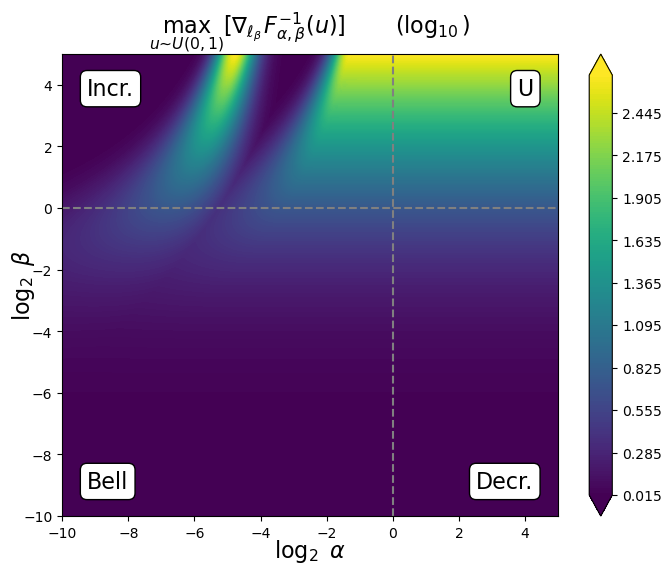

In [45]:
fontsize = 16
use_alpha_beta = True

fig, ax = plt.subplots(figsize=(8, 6))
extent = (low_lim, high_lim, low_lim, high_lim)
vmin = -10

# nabla_a
val = torch.log10(mean_nabla_a_F_inv.abs()).detach().numpy()
text =r'$\mathbb{E}_{u \sim U(0,1)}[\nabla_{\ell_{\alpha}} F_{\alpha, \beta}^{-1}(u)]$       ($\log_{10}$)'
val = torch.log10(std_nabla_a_F_inv.abs()).detach().numpy()
text =r'$\sqrt{\mathbb{V}_{u \sim U(0,1)}[\nabla_{\ell_{\alpha}} F_{\alpha, \beta}^{-1}(u)]}$       ($\log_{10}$)'
val = max_nabla_a_F_inv #torch.log10(max_nabla_a_F_inv.abs()).detach().numpy()
text =r'$\max_{u \sim U(0,1)}[\nabla_{\ell_{\alpha}} F_{\alpha, \beta}^{-1}(u)]$       ($\log_{10}$)'

# nabla_b
#val = torch.log10(mean_nabla_b_F_inv.abs()).detach().numpy()
#text =r'$\mathbb{E}_{u \sim U(0,1)}[\nabla_{\ell_{\beta}} F_{\alpha, \beta}^{-1}(u)]$       ($\log_{10}$)'
#val = torch.log10(std_nabla_b_F_inv.abs()).detach().numpy()
#text =r'$\sqrt{\mathbb{V}_{u \sim U(0,1)}[\nabla_{\ell_{\beta}} F_{\alpha, \beta}^{-1}(u)]}$       ($\log_{10}$)'
val = max_nabla_b_F_inv #torch.log10(max_nabla_a_F_inv.abs()).detach().numpy()
text =r'$\max_{u \sim U(0,1)}[\nabla_{\ell_{\beta}} F_{\alpha, \beta}^{-1}(u)]$       ($\log_{10}$)'

#levels = np.linspace(vmin, vmax, num=200)  # 200 levels from vmin to vmax
cp = ax.contourf(log_alpha, log_beta, val, levels=200, #levels, 
                 cmap='viridis', extend='both',
                 #vmax=.5,
                 #vmin=vmin,
                 )
cbar = plt.colorbar(cp) #, ticks=np.arange(vmin, vmax + 0.5, 0.5), pad=0.01)  # Adjust the ticks if necessary
#cbar.set_label('Entropy (log scale)', rotation=270, labelpad=20)

cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.tick_right()

ax.set_title(text, fontsize=fontsize) # $\log_{10}-H_{\alpha, \beta}$', fontsize=fontsize)

# Adjust labels
ax.set_xlabel(r"$\log_2$ {0}".format(r"$\alpha$" if use_alpha_beta else "a"), fontsize=fontsize)
ax.set_ylabel(r'$\log_2$ {0}'.format(r"$\beta$" if use_alpha_beta else "b"), fontsize=fontsize)
ax.xaxis.labelpad = -2
ax.yaxis.labelpad = -10

# Highlighting points where the mean is ~0.5
#mask = torch.isclose(entropy, torch.tensor(1.0, dtype=dtype), atol=0.01)
#highlighted_points = ax.scatter(log_a_m[mask], log_b_m[mask], color='black', 
#                                label=r'1.0', s=2)
#ax.legend(loc=(.8, 0.75), fontsize=12)

# Adding reference lines and text
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')

# Adjust text annotations to avoid overlapping with the legend
text_props = dict(boxstyle='round', facecolor='white', alpha=1.0)
ax.text(0.95, 0.95, 'U', transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=text_props, fontsize=fontsize)
ax.text(0.05, 0.95, 'Incr.', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=text_props, fontsize=fontsize)
ax.text(0.05, 0.05, 'Bell', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='left', bbox=text_props, fontsize=fontsize)
ax.text(0.95, 0.05, 'Decr.', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=text_props, fontsize=fontsize)

#plt.savefig(FIGURES_DIR + 'entropy_kumaraswamy.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_87152/1406614316.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar


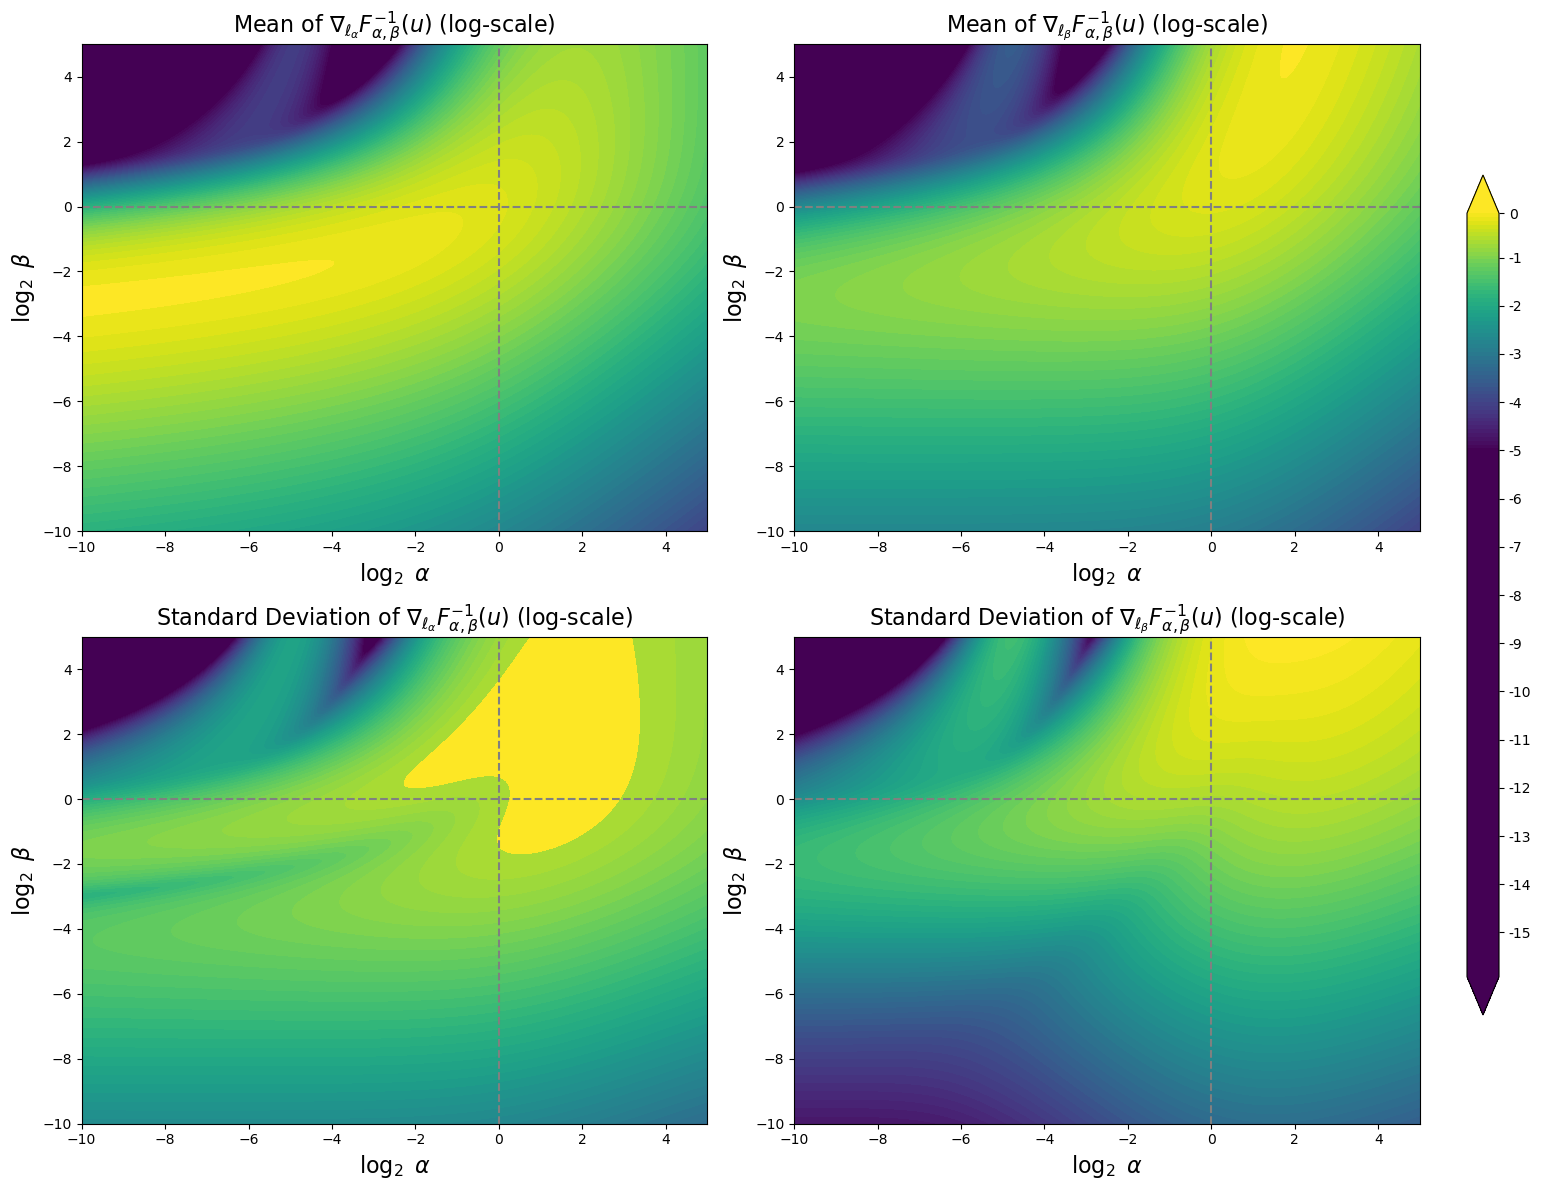

In [49]:
import matplotlib.pyplot as plt
import torch
import numpy as np

fontsize = 16
use_alpha_beta = True

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Defining common parameters
extent = (low_lim, high_lim, low_lim, high_lim)

# Compute global min and max for unified colorbars
eps_min = 1e-16
vals = [
    torch.log10(mean_nabla_a_F_inv.abs() + eps_min).detach().numpy(),
    torch.log10(std_nabla_a_F_inv.abs() + eps_min).detach().numpy(),
    torch.log10(mean_nabla_b_F_inv.abs() + eps_min).detach().numpy(),
    torch.log10(std_nabla_b_F_inv.abs() + eps_min).detach().numpy()
]

vmin = -5 #min(val.min() for val in vals)
vmax = max(val.max() for val in vals)

# Plotting mean_nabla_a_F_inv
val = vals[0]
text = r'Mean of $\nabla_{\ell_{\alpha}} F_{\alpha, \beta}^{-1}(u)$ (log-scale)'
cp = axs[0, 0].contourf(log_alpha, log_beta, val, levels=200, cmap='viridis', extend='both', vmin=vmin, vmax=vmax)
axs[0, 0].set_title(text, fontsize=fontsize)
axs[0, 0].set_xlabel(r"$\log_2$ {0}".format(r"$\alpha$" if use_alpha_beta else "a"), fontsize=fontsize)
axs[0, 0].set_ylabel(r'$\log_2$ {0}'.format(r"$\beta$" if use_alpha_beta else "b"), fontsize=fontsize)
axs[0, 0].axhline(0, color='grey', linestyle='--')
axs[0, 0].axvline(0, color='grey', linestyle='--')

# Plotting std_nabla_a_F_inv
val = vals[1]
text = r'Standard Deviation of $\nabla_{\ell_{\alpha}} F_{\alpha, \beta}^{-1}(u)$ (log-scale)'
cp = axs[1, 0].contourf(log_alpha, log_beta, val, levels=200, cmap='viridis', extend='both', vmin=vmin, vmax=vmax)
axs[1, 0].set_title(text, fontsize=fontsize)
axs[1, 0].set_xlabel(r"$\log_2$ {0}".format(r"$\alpha$" if use_alpha_beta else "a"), fontsize=fontsize)
axs[1, 0].set_ylabel(r'$\log_2$ {0}'.format(r"$\beta$" if use_alpha_beta else "b"), fontsize=fontsize)
axs[1, 0].axhline(0, color='grey', linestyle='--')
axs[1, 0].axvline(0, color='grey', linestyle='--')

# Plotting mean_nabla_b_F_inv
val = vals[2]
text = r'Mean of $\nabla_{\ell_{\beta}} F_{\alpha, \beta}^{-1}(u)$ (log-scale)'
cp = axs[0, 1].contourf(log_alpha, log_beta, val, levels=200, cmap='viridis', extend='both', vmin=vmin, vmax=vmax)
axs[0, 1].set_title(text, fontsize=fontsize)
axs[0, 1].set_xlabel(r"$\log_2$ {0}".format(r"$\alpha$" if use_alpha_beta else "a"), fontsize=fontsize)
axs[0, 1].set_ylabel(r'$\log_2$ {0}'.format(r"$\beta$" if use_alpha_beta else "b"), fontsize=fontsize)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].axvline(0, color='grey', linestyle='--')

# Plotting std_nabla_b_F_inv
val = vals[3]
text = r'Standard Deviation of $\nabla_{\ell_{\beta}} F_{\alpha, \beta}^{-1}(u)$ (log-scale)'
cp = axs[1, 1].contourf(log_alpha, log_beta, val, levels=200, cmap='viridis', extend='both', vmin=vmin, vmax=vmax)
axs[1, 1].set_title(text, fontsize=fontsize)
axs[1, 1].set_xlabel(r"$\log_2$ {0}".format(r"$\alpha$" if use_alpha_beta else "a"), fontsize=fontsize)
axs[1, 1].set_ylabel(r'$\log_2$ {0}'.format(r"$\beta$" if use_alpha_beta else "b"), fontsize=fontsize)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].axvline(0, color='grey', linestyle='--')

# Add a single colorbar with specific ticks
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of colorbar [left, bottom, width, height]
cbar = fig.colorbar(cp, cax=cbar_ax, ticks=np.arange(-15, 1, 1))  # Ticks from 0 to -15 stepping by 1
cbar.ax.set_yticklabels(np.arange(-15, 1, 1))  # Set tick labels

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar
plt.show()
